Data shape: (1715, 201), Number of classes: 7


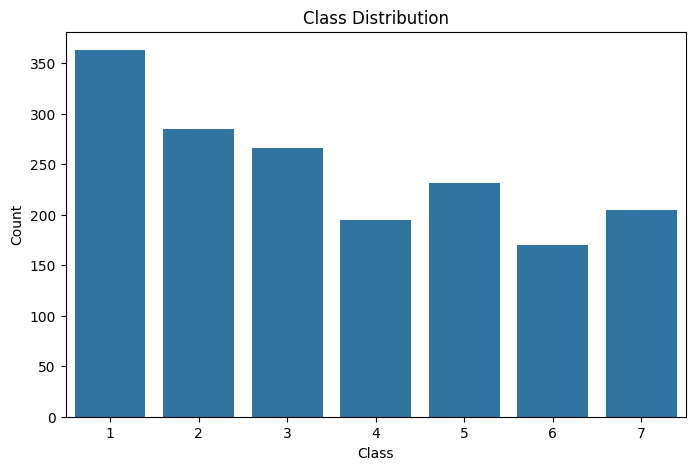

In [179]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, cohen_kappa_score, precision_score

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

import warnings
warnings.filterwarnings('ignore')

# Load data
url = "https://raw.githubusercontent.com/leaLeGallo/big_data_exam/refs/heads/main/Cancer2025exam.csv"
data = pd.read_csv(url)
X = data.iloc[:, 1:].values
y = data.iloc[:, 0].values

print(f"Data shape: {X.shape}, Number of classes: {len(np.unique(y))}")

# Plot class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x=data.columns[0], data=data)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


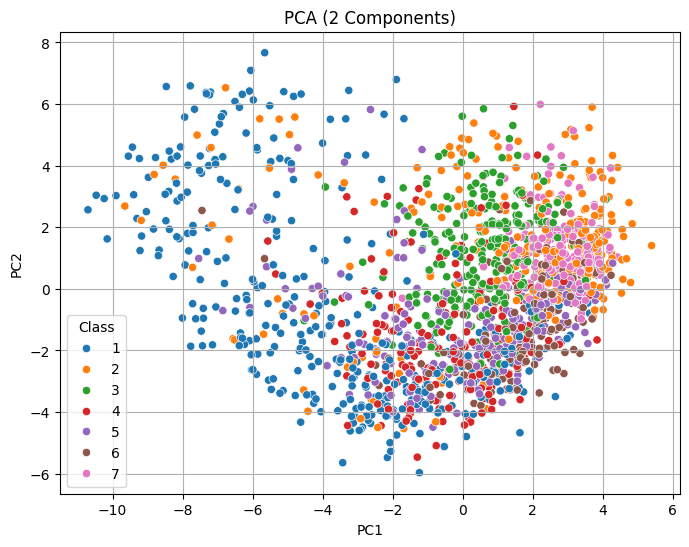

In [180]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# PCA Visualization
def plot_pca(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='tab10')
    plt.title("PCA (2 Components)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(title="Class")
    plt.grid(True)
    plt.show()

plot_pca(X, y)


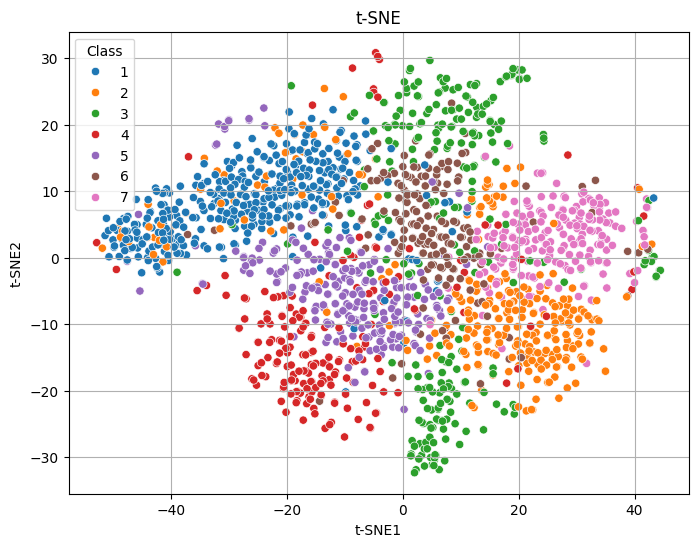

In [181]:

# t-SNE Visualization
def plot_tsne(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    X_tsne = tsne.fit_transform(X_scaled)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette='tab10')
    plt.title("t-SNE")
    plt.xlabel("t-SNE1")
    plt.ylabel("t-SNE2")
    plt.legend(title="Class")
    plt.grid(True)
    plt.show()


plot_tsne(X, y)


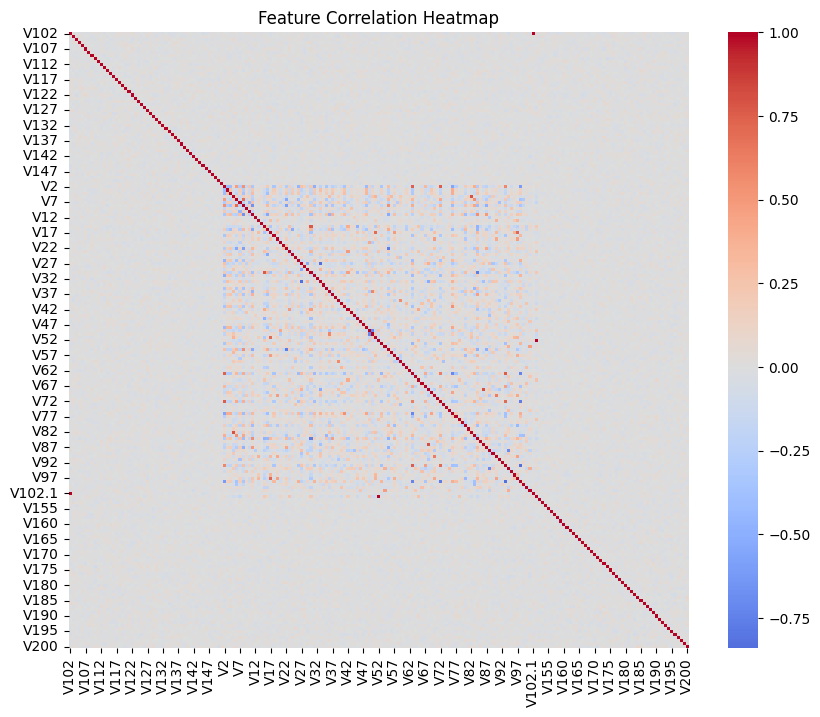

In [182]:
# Correlation heatmap
X_df = pd.DataFrame(X, columns=data.columns[1:])
plt.figure(figsize=(10, 8))
sns.heatmap(X_df.corr(), cmap='coolwarm', center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

In [183]:
def create_outer_splits(X, y, n_splits=5, random_state=42):
    """
    Create stratified splits for outer train-test evaluation.
    Returns list of (train_idx, test_idx) tuples.
    """
    outer_cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    return list(outer_cv.split(X, y))


def get_classifiers():
    """
    Returns dictionary of classifiers to evaluate.
    """
    return {
        'Logistic Regression': LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42),
        'SVM': SVC(probability=True, class_weight='balanced', random_state=42),
        'KNN': KNeighborsClassifier(),
        'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
        'Naive Bayes': GaussianNB(),
        'AdaBoost': AdaBoostClassifier(random_state=42)
    }

def get_param_grids():
    """
    Final hyperparameter grid containing only the best picked values from CV.
    """
    return {
        'Logistic Regression': {
            'clf__C': [0.01],
            'clf__penalty': ['l2'],
            'clf__solver': ['lbfgs'],
            'pca__n_components': [0.99]
        },
        'SVM': {
            'clf__C': [10],
            'clf__kernel': ['rbf'],
            'clf__gamma': ['scale'],
            'pca__n_components': [0.99]
        },
        'KNN': {
            'clf__n_neighbors': [7],
            'clf__weights': ['uniform'],
            'clf__p': [2],
            'pca__n_components': [0.9]
        },
        'Random Forest': {
            'clf__n_estimators': [400],
            'clf__max_depth': [10],
            'clf__min_samples_split': [5],
            'clf__min_samples_leaf': [2],
            'clf__bootstrap': [True],
            'pca__n_components': [0.99]
        },
        'Naive Bayes': {
            'pca__n_components': [0.9]
        },
        'AdaBoost': {
            'clf__n_estimators': [200],
            'clf__learning_rate': [1.0],
            'pca__n_components': [0.95]
        }
    }


# def get_param_grids():
#     """
#     Slightly expanded but still computationally feasible hyperparameter grids.
#     """
#     return {
#         'Logistic Regression': {
#             'clf__C': [0.001, 0.01, 0.1],
#             'clf__penalty': ['l2'],
#             'clf__solver': ['lbfgs']
#         },
#         'SVM': {
#             'clf__C': [0.1, 1, 10],
#             'clf__kernel': ['rbf'],
#             'clf__gamma': ['scale', 'auto']
#         },
#         'KNN': {
#             'clf__n_neighbors': [3, 5, 7, 9],
#             'clf__weights': ['uniform', 'distance'],
#             'clf__p': [1, 2]  # Manhattan and Euclidean — can differ a lot in practice
#         },
#         'Random Forest': {
#             'clf__n_estimators': [300, 400],
#             'clf__max_depth': [10],
#             'clf__min_samples_split': [5],
#             'clf__min_samples_leaf': [2],
#             'clf__bootstrap': [True]
#         },
#         'Naive Bayes': {
#             # nothing to tune
#         },
#         'AdaBoost': {
#             'clf__n_estimators': [50, 100, 200],
#             'clf__learning_rate': [0.01, 0.1, 1.0]
#         }
#     }




In [184]:
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline

def build_pipeline(classifier):
    """
    Build pipeline with StandardScaler, PCA, SMOTE, and classifier.
    """
    pipe = ImbPipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(random_state=42)),
        ('smote', SMOTE(random_state=42)),
        ('clf', classifier)
    ])
    return pipe

def tune_model(X_train, y_train, pipeline, param_grid, inner_cv=5):
    """
    Tune hyperparameters of a prebuilt pipeline using GridSearchCV.
    """
    gs = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=inner_cv,
        scoring='balanced_accuracy',
        n_jobs=-1,
        verbose=1
    )
    gs.fit(X_train, y_train)
    return gs.best_estimator_, gs.best_params_



In [185]:
from sklearn.metrics import balanced_accuracy_score, f1_score

def evaluate_model(model, X_test, y_test, confidence_threshold=0.90):
    """
    Evaluate the trained model on test data, including confidence and set prediction.
    Returns a dictionary with metrics and arrays for confidence analysis.
    """
    y_pred = model.predict(X_test)
    probas = model.predict_proba(X_test)  # probability of each class

    classes = np.unique(y_test)
    cm = confusion_matrix(y_test, y_pred, labels=classes)

    # Basic metrics
    accuracy = accuracy_score(y_test, y_pred)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average="macro", zero_division=0)

    sensitivity = []
    specificity = []
    precision = []

    for i, cls in enumerate(classes):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = cm.sum() - TP - FP - FN

        sens = TP / (TP + FN) if (TP + FN) > 0 else 0
        spec = TN / (TN + FP) if (TN + FP) > 0 else 0
        prec = TP / (TP + FP) if (TP + FP) > 0 else 0

        sensitivity.append(sens)
        specificity.append(spec)
        precision.append(prec)

    # 1) Confidence analysis: max predicted probability per sample
    max_probas = np.max(probas, axis=1)
    is_confident = max_probas >= confidence_threshold

    # 2) Prediction sets for uncertain cases (prob < threshold)
    #    Include all classes whose predicted probability >= (1 - threshold)
    prediction_sets = []
    for p in probas:
        prediction_sets.append([classes[j] for j, prob in enumerate(p) if prob >= (1 - confidence_threshold)])

    # 3) Potential mislabeled: high-confidence errors
    potential_mislabeled = [
        i for i, (pred, true, conf) in enumerate(zip(y_pred, y_test, max_probas))
        if (pred != true) and (conf >= confidence_threshold)
    ]

    return {
        'accuracy': accuracy,
        'balanced_accuracy': balanced_acc,
        'kappa': kappa,
        'f1_macro': f1_macro,
        'confusion_matrix': cm,
        'sensitivity_per_class': sensitivity,
        'specificity_per_class': specificity,
        'precision_per_class': precision,
        'max_probas': max_probas,
        'is_confident': is_confident,
        'prediction_sets': prediction_sets,
        'potential_mislabeled_indices': potential_mislabeled
    }


In [186]:
def transform_features_only(pipeline, X):
    """
    Applies only scaler and PCA from the pipeline (not SMOTE).
    otherwise i cannot get the rf confidence vote!!
    """
    scaler = pipeline.named_steps['scaler']
    pca = pipeline.named_steps['pca']
    return pca.transform(scaler.transform(X))


In [187]:
def get_rf_confidence(rf_model, X, y_true, threshold=0.9):
    """
    Estimate confidence for Random Forest predictions by checking tree vote proportions.
    """
    n_samples = X.shape[0]
    n_classes = len(np.unique(y_true))
    n_trees = len(rf_model.estimators_)

    tree_preds = np.zeros((n_trees, n_samples), dtype=int)
    for i, tree in enumerate(rf_model.estimators_):
        tree_preds[i] = tree.predict(X)

    vote_counts = np.apply_along_axis(
        lambda x: np.bincount(x, minlength=n_classes), axis=0, arr=tree_preds
    )

    vote_proportions = vote_counts / n_trees
    max_probas = vote_proportions.max(axis=0)
    is_confident = max_probas >= threshold

    final_preds = rf_model.predict(X)
    potential_mislabeled = (final_preds != y_true) & is_confident

    return {
        'max_probas': max_probas,
        'is_confident': is_confident,
        'prediction_sets': vote_counts.argmax(axis=0),
        'potential_mislabeled_indices': np.where(potential_mislabeled)[0]
    }


In [213]:
from sklearn.model_selection import StratifiedKFold
from collections import defaultdict

def outer_cv_runner(X, y, classifiers, param_grids, outer_splits=3, inner_splits=5, confidence_threshold=0.90, random_state=42):
    """
    Perform nested CV with inner tuning and confidence analysis.
    Takes prebuilt pipelines (not raw classifiers).
    Returns a dict: {classifier_name: [list_of_per-fold results]}.
    """
    all_results = defaultdict(list)
    outer_cv = StratifiedKFold(n_splits=outer_splits, shuffle=True, random_state=random_state)

    for fold_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), start=1):
        print(f"\n--- Outer fold {fold_idx} ---")
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        for clf_name, pipeline in classifiers.items():
            print(f"Tuning and evaluating {clf_name}...")

            param_grid = param_grids.get(clf_name, {})
            best_model, best_params = tune_model(X_train, y_train, pipeline, param_grid, inner_cv=inner_splits)

            eval_metrics = evaluate_model(best_model, X_test, y_test, confidence_threshold=confidence_threshold)
            eval_metrics['best_params'] = best_params
            eval_metrics['fold'] = fold_idx
            eval_metrics['test_indices'] = test_idx

            # Random Forest confidence analysis
            if "random forest" in clf_name.lower():
                print("yess random forest!")
                rf = best_model.named_steps['clf']
                X_test_preprocessed = transform_features_only(best_model, X_test)

                rf_conf_analysis = get_rf_confidence(
                    rf, X_test_preprocessed, y_test, threshold=confidence_threshold
                )

                eval_metrics['tree_vote_confidence'] = {
                    'n_confident': int(np.sum(rf_conf_analysis['is_confident'])),
                    'n_uncertain': int(np.sum(~rf_conf_analysis['is_confident'])),
                    'confidence_scores': rf_conf_analysis['max_probas'].tolist(),
                    'predicted_labels': rf_conf_analysis['prediction_sets'].tolist(),
                    'high_confidence_errors': rf_conf_analysis['potential_mislabeled_indices'].tolist()
                }

                print(eval_metrics)

            all_results[clf_name].append(eval_metrics)

    return all_results



## get evaluation metrics for prints and plots

In [214]:
def aggregate_cv_results(results, classes):
    """
    Aggregate nested CV results across folds, including ensemble confidence/mislabeled info.
    """
    agg_results = {}

    for clf_name, folds in results.items():
        # Collect arrays for numeric metrics
        accuracy_arr, balanced_acc_arr, f1_macro_arr = [], [], []
        sensitivity_arr, specificity_arr, precision_arr = [], [], []
        confusion_matrices = []

        # Confidence analysis (softmax-based)
        all_max_probas = []
        all_is_confident = []
        all_pred_sets = []
        all_potential_mislabeled = []

        # Tree-vote confidence analysis (for ensemble models)
        tree_vote_confidences = []
        tree_vote_high_conf_errors = []
        tree_vote_n_confident = []
        tree_vote_n_uncertain = []

        for fold_res in folds:
            accuracy_arr.append(fold_res['accuracy'])
            balanced_acc_arr.append(fold_res['balanced_accuracy'])
            f1_macro_arr.append(fold_res['f1_macro'])
            sensitivity_arr.append(fold_res['sensitivity_per_class'])
            specificity_arr.append(fold_res['specificity_per_class'])
            precision_arr.append(fold_res['precision_per_class'])

            all_max_probas.extend(fold_res['max_probas'])
            all_is_confident.extend(fold_res['is_confident'])
            all_pred_sets.extend(fold_res['prediction_sets'])

            fold_misl = [
                (fold_res['fold'], fold_res['test_indices'][i])
                for i in fold_res['potential_mislabeled_indices']
            ]
            all_potential_mislabeled.extend(fold_misl)

            confusion_matrices.append(fold_res['confusion_matrix'])

            # Handle ensemble confidence info (only if available)
            if 'tree_vote_confidence' in fold_res:
                tree_vote_conf = fold_res['tree_vote_confidence']
                tree_vote_confidences.extend(tree_vote_conf['confidence_scores'])
                tree_vote_high_conf_errors.extend(tree_vote_conf['high_confidence_errors'])
                tree_vote_n_confident.append(tree_vote_conf['n_confident'])
                tree_vote_n_uncertain.append(tree_vote_conf['n_uncertain'])

        # Convert to NumPy arrays
        accuracy_arr = np.array(accuracy_arr)
        balanced_acc_arr = np.array(balanced_acc_arr)
        f1_macro_arr = np.array(f1_macro_arr)
        sensitivity_arr = np.array(sensitivity_arr)
        specificity_arr = np.array(specificity_arr)
        precision_arr = np.array(precision_arr)
        confusion_sum = np.sum(confusion_matrices, axis=0)

        clf_result = {
            'accuracy_mean': np.mean(accuracy_arr),
            'accuracy_std': np.std(accuracy_arr),
            'balanced_accuracy_mean': np.mean(balanced_acc_arr),
            'balanced_accuracy_std': np.std(balanced_acc_arr),
            'f1_macro_mean': np.mean(f1_macro_arr),
            'f1_macro_std': np.std(f1_macro_arr),
            'sensitivity_mean_per_class': np.mean(sensitivity_arr, axis=0),
            'sensitivity_std_per_class': np.std(sensitivity_arr, axis=0),
            'specificity_mean_per_class': np.mean(specificity_arr, axis=0),
            'specificity_std_per_class': np.std(specificity_arr, axis=0),
            'precision_mean_per_class': np.mean(precision_arr, axis=0),
            'precision_std_per_class': np.std(precision_arr, axis=0),
            'confusion_matrix_sum': confusion_sum,

            # Confidence-related aggregates
            'all_max_probas': np.array(all_max_probas),
            'all_is_confident': np.array(all_is_confident),
            'all_prediction_sets': all_pred_sets,
            'all_potential_mislabeled': all_potential_mislabeled
        }

        if tree_vote_confidences:
            clf_result.update({
                'tree_vote_confidence_mean': np.mean(tree_vote_confidences),
                'tree_vote_confidence_std': np.std(tree_vote_confidences),
                'tree_vote_confidence_scores': tree_vote_confidences,
                'tree_vote_high_confidence_errors': tree_vote_high_conf_errors,
                'tree_vote_n_confident_mean': np.mean(tree_vote_n_confident),
                'tree_vote_n_uncertain_mean': np.mean(tree_vote_n_uncertain),
            })

        agg_results[clf_name] = clf_result

    return agg_results


In [215]:
def print_summary_metrics(agg_results, classes, confidence_threshold=0.90):
    """
    Print aggregated performance and confidence/mislabeled information.
    """
    for clf_name, metrics in agg_results.items():
        print(f"\n=== {clf_name} ===")
        print(f"Accuracy: {metrics['accuracy_mean']:.3f} ± {metrics['accuracy_std']:.3f}")
        print(f"Balanced Accuracy: {metrics['balanced_accuracy_mean']:.3f} ± {metrics['balanced_accuracy_std']:.3f}")
        print(f"F1 Macro: {metrics['f1_macro_mean']:.3f} ± {metrics['f1_macro_std']:.3f}")

        print("Per-class Sensitivity (Recall):")
        for cls, mean_sens, std_sens in zip(classes,
                                            metrics['sensitivity_mean_per_class'],
                                            metrics['sensitivity_std_per_class']):
            print(f"  Class {cls}: {mean_sens:.3f} ± {std_sens:.3f}")

        print("Per-class Specificity:")
        for cls, mean_spec, std_spec in zip(classes,
                                            metrics['specificity_mean_per_class'],
                                            metrics['specificity_std_per_class']):
            print(f"  Class {cls}: {mean_spec:.3f} ± {std_spec:.3f}")

        print("Per-class Precision:")
        for cls, mean_prec, std_prec in zip(classes,
                                            metrics['precision_mean_per_class'],
                                            metrics['precision_std_per_class']):
            print(f"  Class {cls}: {mean_prec:.3f} ± {std_prec:.3f}")

        # Confidence summary
        total_predictions = len(metrics['all_is_confident'])
        confident_count = np.sum(metrics['all_is_confident'])
        uncertain_count = total_predictions - confident_count
        print(f"Confident predictions (prob ≥ {confidence_threshold}): {confident_count}/{total_predictions}")
        print(f"Uncertain predictions (prob < {confidence_threshold}): {uncertain_count}/{total_predictions}")

        # Potential mislabeled
        suspected = metrics['all_potential_mislabeled']
        print(f"Total potential mislabeled instances (high-confidence errors): {len(suspected)}")
        if suspected:
            print("Example suspected mislabeled (fold_index, global_index):", suspected[:5])


In [192]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, classes, title):
    """
    Plot a normalized confusion matrix as a heatmap.
    """
    cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_norm, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes, cmap='Blues')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(title)
    plt.show()



In [233]:
# import matplotlib.pyplot as plt
# import numpy as np
# def plot_tree_vote_confidence(results, clf_name):
#     if clf_name not in results:
#         print(f"{clf_name} not found in results.")
#         return

#     all_confidences = []
#     for fold_result in results[clf_name]:
#         confidence_data = fold_result.get('tree_vote_confidence')
#         if confidence_data and 'confidence_scores' in confidence_data:
#             all_confidences.extend(confidence_data['confidence_scores'])

#     if not all_confidences:
#         print(f"No tree-vote confidence data found for {clf_name}")
#         return

#     plt.figure(figsize=(8, 4))
#     plt.hist(all_confidences, bins=20, alpha=0.7, color='darkblue')
#     plt.axvline(np.mean(all_confidences), color='red', linestyle='--', label='Mean Confidence')
#     plt.title(f"Tree-Vote Confidence Scores Distribution ({clf_name})")
#     plt.xlabel("Confidence (fraction of agreeing trees)")
#     plt.ylabel("Number of Instances")
#     plt.legend()
#     plt.tight_layout()
#     plt.show()


# def plot_confidence_vs_accuracy(results, clf_name, threshold=0.9):
#     if clf_name not in results:
#         print(f"{clf_name} not found in results.")
#         return

#     confidences = []
#     correctness = []
#     for fold_result in results[clf_name]:
#         conf_data = fold_result.get('tree_vote_confidence')
#         if conf_data and 'confidence_scores' in conf_data and 'high_confidence_errors' in conf_data:
#             scores = conf_data['confidence_scores']
#             errors = conf_data['high_confidence_errors']
#             n = len(scores)
#             for i in range(n):
#                 confidences.append(scores[i])
#                 correctness.append(0 if i in errors else 1)  # 0 = wrong, 1 = correct

#     if not confidences:
#         print(f"No confidence data found for {clf_name}")
#         return

#     plt.figure(figsize=(8, 5))
#     plt.scatter(confidences, correctness, alpha=0.3, edgecolors='none')
#     plt.axvline(threshold, color='red', linestyle='--', label=f'Confidence Threshold {threshold}')
#     plt.yticks([0, 1], ['Wrong', 'Correct'])
#     plt.xlabel('Confidence (Fraction of agreeing trees)')
#     plt.ylabel('Prediction Correctness')
#     plt.title(f'Confidence vs Accuracy ({clf_name})')
#     plt.legend()
#     plt.tight_layout()
#     plt.show()




In [218]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def plot_boxplots(results, metric_names=['accuracy', 'balanced_accuracy']):
    """
    Plot boxplots for specified metrics across classifiers.
    """
    data = []
    for clf_name, folds in results.items():
        for fold in folds:
            for metric in metric_names:
                if metric in fold:
                    data.append({'Classifier': clf_name, 'Metric': metric, 'Score': fold[metric]})
    df = pd.DataFrame(data)
    g = sns.catplot(
        data=df,
        x="Classifier",
        y="Score",
        hue="Metric",
        kind="box",
        height=6,
        aspect=1.5
    )
    g.set_xticklabels(rotation=45)
    g.set_titles("Per-Fold Evaluation Metrics")
    g.fig.suptitle("Boxplot of Metrics per Classifier", fontsize=16)
    plt.tight_layout()
    plt.show()

In [196]:
raw_classifiers = get_classifiers()
classifiers = {name: build_pipeline(clf) for name, clf in raw_classifiers.items()}

param_grids = get_param_grids()

results = outer_cv_runner(
    X, y,
    classifiers,
    param_grids,
    outer_splits=3,
    inner_splits=5,
    confidence_threshold=0.90
)



--- Outer fold 1 ---
Tuning and evaluating Logistic Regression...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Tuning and evaluating SVM...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Tuning and evaluating KNN...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Tuning and evaluating Random Forest...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
yess random forest!
Tuning and evaluating Naive Bayes...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Tuning and evaluating AdaBoost...
Fitting 5 folds for each of 1 candidates, totalling 5 fits

--- Outer fold 2 ---
Tuning and evaluating Logistic Regression...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Tuning and evaluating SVM...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Tuning and evaluating KNN...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Tuning and evaluating Random Forest...
Fitting 5 folds for each of 1 candidates, totallin

In [198]:
from sklearn.metrics import balanced_accuracy_score
def get_best_overall_params(results):
    """
    For each model, find the best parameter set across all folds based on accuracy.
    """
    print("Best Overall Parameters per Model (based on highest accuracy):\n")

    for model_name, fold_results in results.items():
        best_fold = max(fold_results, key=lambda x: x['balanced_accuracy'])
        best_params = best_fold['best_params']
        best_score = best_fold['accuracy']
        fold_num = best_fold['fold']

        print(f"{model_name}:")
        print(f"  Fold: {fold_num}")
        print(f"  Accuracy: {best_score:.4f}")
        for k, v in best_params.items():
            print(f"    {k}: {v}")
        print()


In [212]:
#get_best_overall_params(results)

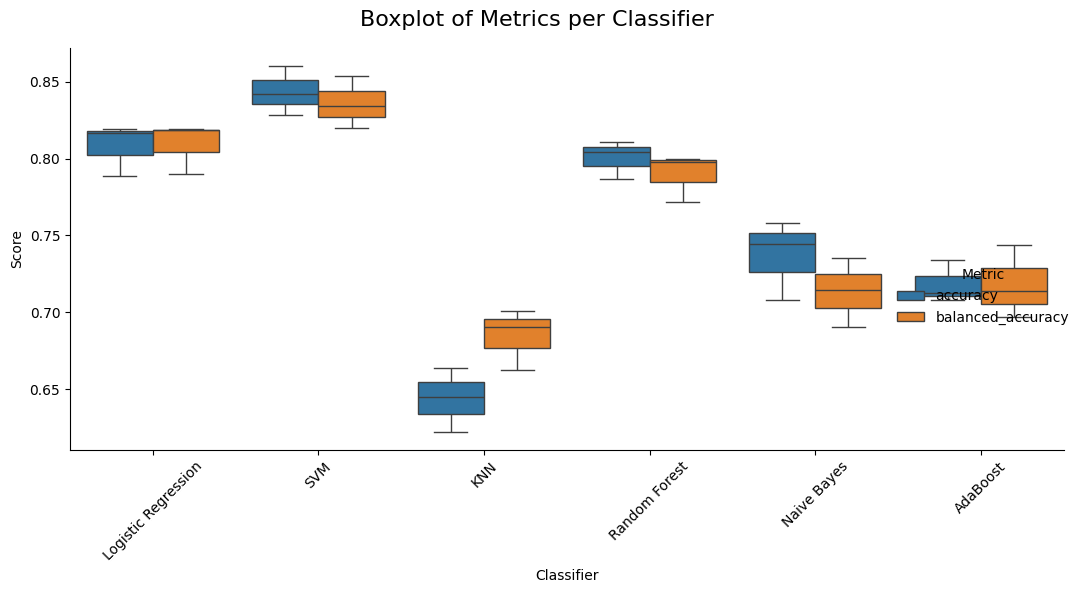

dict_keys(['Logistic Regression', 'SVM', 'KNN', 'Random Forest', 'Naive Bayes', 'AdaBoost', 'RandomForest'])


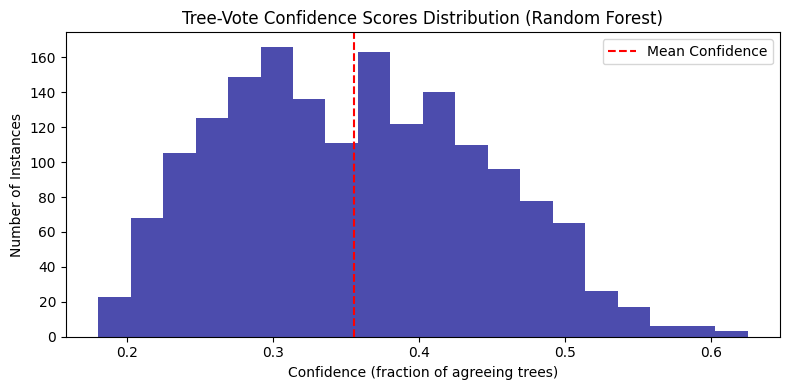

In [235]:
classes = np.unique(y)
agg_results = aggregate_cv_results(results, classes)


# Print summary metrics
print_summary_metrics(agg_results, classes, confidence_threshold=0.90)

# plot boxplots
plot_boxplots(results)

#plot ensemble confidence (e.g. for Random Forest)
print(results.keys())
#plot_tree_vote_confidence(results, clf_name='Random Forest')

# plot confusion matrices
for clf_name, metrics in agg_results.items():
    plot_confusion_matrix(
        metrics['confusion_matrix_sum'],
        classes,
        title=f"{clf_name} – Confusion Matrix (Aggregated)"
    )

## question 1c

In [201]:
from sklearn.decomposition import PCA, KernelPCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

def generate_reduction_classification_pipelines():
    reducers = {
        'PCA': PCA(random_state=42),
        'KernelPCA': KernelPCA(kernel='rbf', fit_inverse_transform=True, random_state=42),
        'SelectKBest': SelectKBest(score_func=f_classif)
    }

    classifiers = {
        'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
        'SVM': SVC(probability=True, random_state=42),
        'RandomForest': RandomForestClassifier(random_state=42)
    }

    pipelines = {}

    for red_name, reducer in reducers.items():
        for clf_name, clf in classifiers.items():
            name = f"{red_name} + {clf_name}"
            pipe = ImbPipeline([
                ('scaler', StandardScaler()),
                ('reducer', reducer),
                ('smote', SMOTE(random_state=42)),
                ('clf', clf)
            ])
            pipelines[name] = pipe

    return pipelines


In [210]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_performance_and_stability(results, metric='balanced_accuracy'):
    """
    Plots:
    1) Barplot with mean ± std of the given metric per classifier/dim_reduction combo.
    2) Boxplot showing fold-level distribution (stability) for the same metric.

    Args:
        results (dict): Nested CV results dict with structure {combo_name: [fold_results, ...]}.
        metric (str): Metric name to plot (default 'balanced_accuracy').
    """
    # Aggregate mean and std per combo
    records = []
    for combo_name, folds in results.items():
        scores = [fold[metric] for fold in folds if metric in fold]
        mean_score = np.mean(scores)
        std_score = np.std(scores)
        records.append({'Combination': combo_name, 'Mean': mean_score, 'Std': std_score, 'Scores': scores})

    df_summary = pd.DataFrame(records).sort_values(by='Mean', ascending=False).reset_index(drop=True)

    # Prepare data for boxplot (stability)
    fold_rows = []
    for _, row in df_summary.iterrows():
        combo = row['Combination']
        for score in row['Scores']:
            fold_rows.append({'Combination': combo, metric: score})
    df_folds = pd.DataFrame(fold_rows)

    # Boxplot of fold-level metric distribution
    plt.figure(figsize=(14,7))
    sns.boxplot(x='Combination', y=metric, data=df_folds, palette='Set2')
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Stability Across Folds: {metric.replace("_", " ").title()} Distribution')
    plt.ylabel(metric.replace("_", " ").title())
    plt.xlabel('')
    plt.tight_layout()
    plt.show()


In [202]:
def get_param_grids_for_1c():
    return {
        'PCA + LogisticRegression': {
            'reducer__n_components': [0.90, 0.95],
            'clf__C': [0.1, 1.0]
        },
        'PCA + SVM': {
            'reducer__n_components': [0.90, 0.95],
            'clf__C': [0.1, 1.0]
        },
        'PCA + RandomForest': {
            'reducer__n_components': [0.90, 0.95],
            'clf__n_estimators': [50, 100]
        },
        'KernelPCA + LogisticRegression': {
            'reducer__n_components': [10, 20],
            'clf__C': [0.1, 1.0]
        },
        'KernelPCA + SVM': {
            'reducer__n_components': [10, 20],
            'clf__C': [0.1, 1.0]
        },
        'KernelPCA + RandomForest': {
            'reducer__n_components': [10, 20],
            'clf__n_estimators': [50, 100]
        },
        'SelectKBest + LogisticRegression': {
            'reducer__k': [10, 20],
            'clf__C': [0.1, 1.0]
        },
        'SelectKBest + SVM': {
            'reducer__k': [10, 20],
            'clf__C': [0.1, 1.0]
        },
        'SelectKBest + RandomForest': {
            'reducer__k': [10, 20],
            'clf__n_estimators': [50, 100]
        }
    }


In [203]:
pipelines_1c = generate_reduction_classification_pipelines()
param_grids_1c = get_param_grids_for_1c()

results_1c = outer_cv_runner(
    X, y,
    classifiers=pipelines_1c,
    param_grids=param_grids_1c,
    outer_splits=3,
    inner_splits=5,
    confidence_threshold=0.90
)



--- Outer fold 1 ---
Tuning and evaluating PCA + LogisticRegression...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Tuning and evaluating PCA + SVM...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Tuning and evaluating PCA + RandomForest...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Tuning and evaluating KernelPCA + LogisticRegression...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Tuning and evaluating KernelPCA + SVM...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Tuning and evaluating KernelPCA + RandomForest...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Tuning and evaluating SelectKBest + LogisticRegression...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Tuning and evaluating SelectKBest + SVM...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Tuning and evaluating SelectKBest + RandomForest...
Fitting 5 folds for each of 4 candidates, totalling 20 fits

--- Oute


=== PCA + LogisticRegression ===
Accuracy: 0.762 ± 0.014
Balanced Accuracy: 0.764 ± 0.015
F1 Macro: 0.765 ± 0.014
Per-class Sensitivity (Recall):
  Class 1: 0.777 ± 0.040
  Class 2: 0.635 ± 0.026
  Class 3: 0.793 ± 0.035
  Class 4: 0.754 ± 0.044
  Class 5: 0.835 ± 0.027
  Class 6: 0.724 ± 0.042
  Class 7: 0.829 ± 0.037
Per-class Specificity:
  Class 1: 0.950 ± 0.007
  Class 2: 0.914 ± 0.011
  Class 3: 0.961 ± 0.012
  Class 4: 0.970 ± 0.008
  Class 5: 0.977 ± 0.008
  Class 6: 0.968 ± 0.013
  Class 7: 0.979 ± 0.010
Per-class Precision:
  Class 1: 0.809 ± 0.015
  Class 2: 0.597 ± 0.032
  Class 3: 0.790 ± 0.052
  Class 4: 0.765 ± 0.035
  Class 5: 0.852 ± 0.046
  Class 6: 0.720 ± 0.073
  Class 7: 0.854 ± 0.066
Confident predictions (prob ≥ 0.9): 904/1715
Uncertain predictions (prob < 0.9): 811/1715
Total potential mislabeled instances (high-confidence errors): 80
Example suspected mislabeled (fold_index, global_index): [(1, np.int64(192)), (1, np.int64(203)), (1, np.int64(354)), (1, np.int

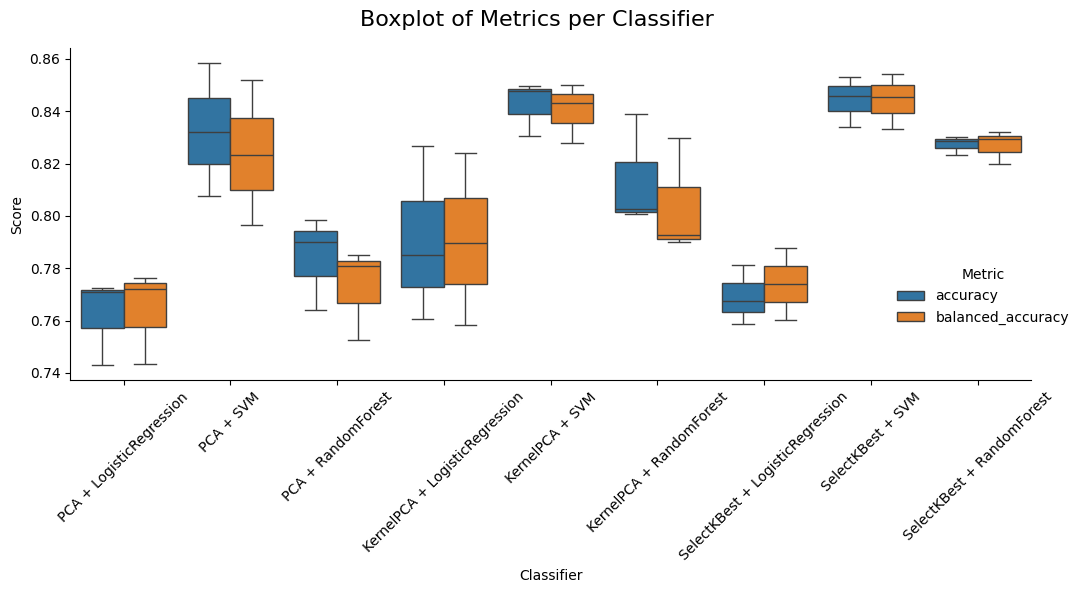

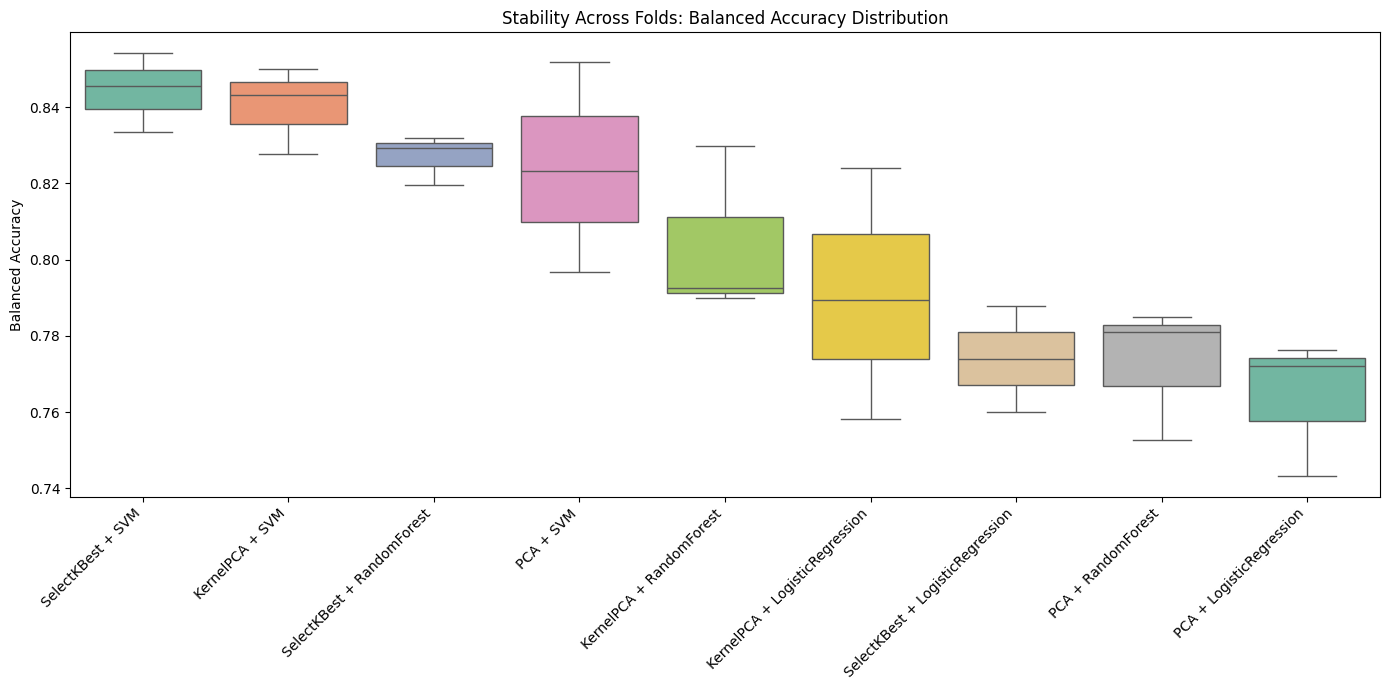

In [220]:
agg_1c = aggregate_cv_results(results_1c, classes)

print_summary_metrics(agg_1c, classes)

plot_boxplots(results_1c)
plot_performance_and_stability(results_1c)

